In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import math
import pprint as pp

from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
# import seaborn as sns

In [2]:
def _in(path):
    return os.path.join('data', path)

def _out(path):
    return os.path.join('./', path)

d_src = pd.read_csv(_in('train.csv'))
d_src.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
t_src = pd.read_csv(_in('test.csv'))
t_src.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


---
### data analysis

In [4]:
# 各列の値
d_src.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


ユニークな値の個数を調べる

In [5]:
uniq_of_cols = []

def __is_column_name(u):
    return type(u) == str or type(u) == bool

def show_unique(d, col):
    """
    ユニークな値の個数とその中のTransported率を集めながら表示する。
    Parameters:
        d: 対象データ
        col: 対象カラム
    """
    du = d[col].unique()
    print('------')
    print(col)
    print(d[col].dtype)
    print(du)
    print(len(du))
    # count rows for each unique values
    if len(du) < 20:
        _cc = []
        du = du.tolist()
        for u in du:
            if __is_column_name(u):
                col_uniq = d[d[col] == u]
            elif np.isnan(u):
                col_uniq = d[d[col].isnull()]
                du = [x if __is_column_name(x) else 'nan' for x in du]
            else:
                raise Exception(f'{type(u)} is unexpected type')
            _cc.append((int(col_uniq.shape[0]), float(col_uniq['Transported'].sum()) / col_uniq.shape[0]))
            print(f'{u}: {col_uniq.shape[0]}, Transported={col_uniq["Transported"].sum()}')
        return (col, du, _cc)
    else:
        print(f'nan: {len(d[d[col].isna()])}')
        return None
    
print(d_src.columns.values)
for c in d_src:
    u = show_unique(d_src, c)
    if u is not None:
        uniq_of_cols.append(u)

['PassengerId' 'HomePlanet' 'CryoSleep' 'Cabin' 'Destination' 'Age' 'VIP'
 'RoomService' 'FoodCourt' 'ShoppingMall' 'Spa' 'VRDeck' 'Name'
 'Transported']
------
PassengerId
object
['0001_01' '0002_01' '0003_01' ... '9279_01' '9280_01' '9280_02']
8693
nan: 0
------
HomePlanet
object
['Europa' 'Earth' 'Mars' nan]
4
Europa: 2131, Transported=1404
Earth: 4602, Transported=1951
Mars: 1759, Transported=920
nan: 201, Transported=103
------
CryoSleep
object
[False True nan]
3
False: 5439, Transported=1789
True: 3037, Transported=2483
nan: 217, Transported=106
------
Cabin
object
['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']
6561
nan: 199
------
Destination
object
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
4
TRAPPIST-1e: 5915, Transported=2787
PSO J318.5-22: 796, Transported=401
55 Cancri e: 1800, Transported=1098
nan: 182, Transported=92
------
Age
float64
[39. 24. 58. 33. 16. 44. 26. 28. 35. 14. 34. 45. 32. 48. 31. 27.  0.  1.
 49. 29. 10.  7. 21. 62. 15. 43. 47.  2. 20

In [6]:
# Cabin列はスラッシュ区切りのため分割してみる
# 客室番号：deck/num/side：sideはP(port=左)とS(starboard=右)
CABIN_COLUMNS = ['Cabin_deck', 'Cabin_num', 'Cabin_side']

def __split_cabin(d):
    return d.split('/')

def split_cabin(d):
    d = d.copy()
    _has_cabin = ~d['Cabin'].isna()
    d.loc[_has_cabin, 'Cabin_deck'], d.loc[_has_cabin, 'Cabin_num'], d.loc[_has_cabin, 'Cabin_side'] = zip(*d[_has_cabin]['Cabin'].apply(__split_cabin))
    d['Cabin_num'] = pd.to_numeric(d['Cabin_num'], errors='coerce')
    return d

d_cab = split_cabin(d_src)
d_cab[CABIN_COLUMNS].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Cabin_deck  8494 non-null   object 
 1   Cabin_num   8494 non-null   float64
 2   Cabin_side  8494 non-null   object 
dtypes: float64(1), object(2)
memory usage: 203.9+ KB


In [7]:
for c in CABIN_COLUMNS:
    u = show_unique(d_cab, c)
    if u is not None:
        uniq_of_cols.append(u)

------
Cabin_deck
object
['B' 'F' 'A' 'G' nan 'E' 'D' 'C' 'T']
9
B: 779, Transported=572
F: 2794, Transported=1229
A: 256, Transported=127
G: 2559, Transported=1321
nan: 199, Transported=100
E: 876, Transported=313
D: 478, Transported=207
C: 747, Transported=508
T: 5, Transported=1
------
Cabin_num
float64
[0.000e+00 1.000e+00 2.000e+00 ... 1.892e+03 1.893e+03 1.894e+03]
1818
nan: 199
------
Cabin_side
object
['P' 'S' nan]
3
P: 4206, Transported=1898
S: 4288, Transported=2380
nan: 199, Transported=100


ユニークな値の個数の分布

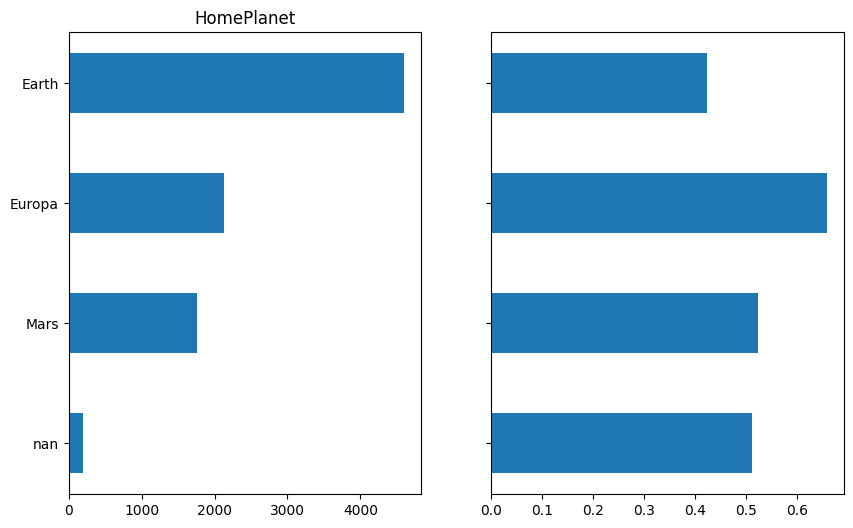

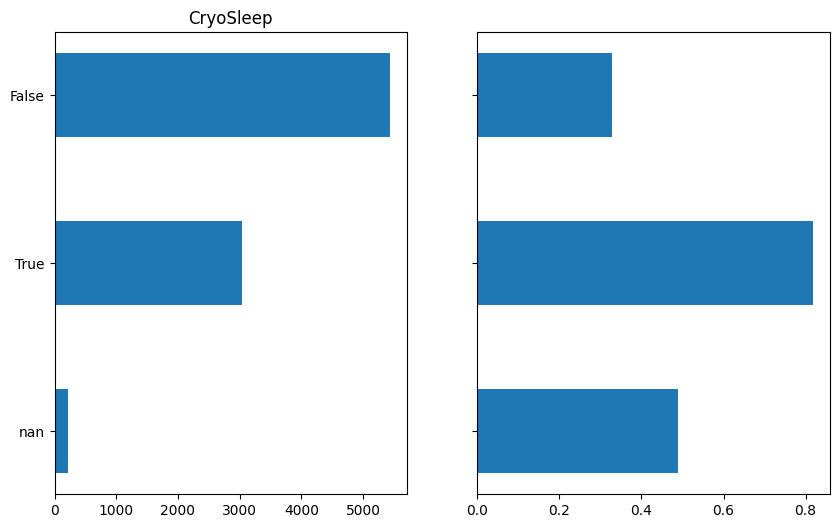

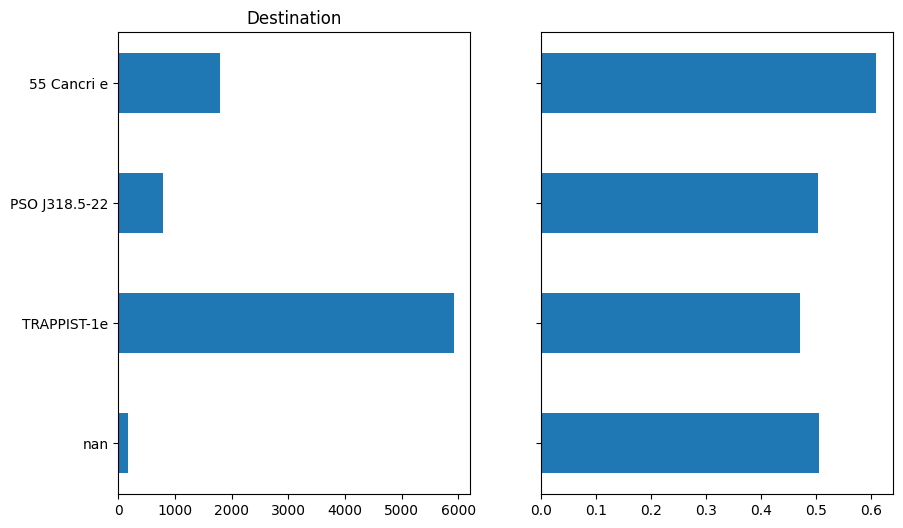

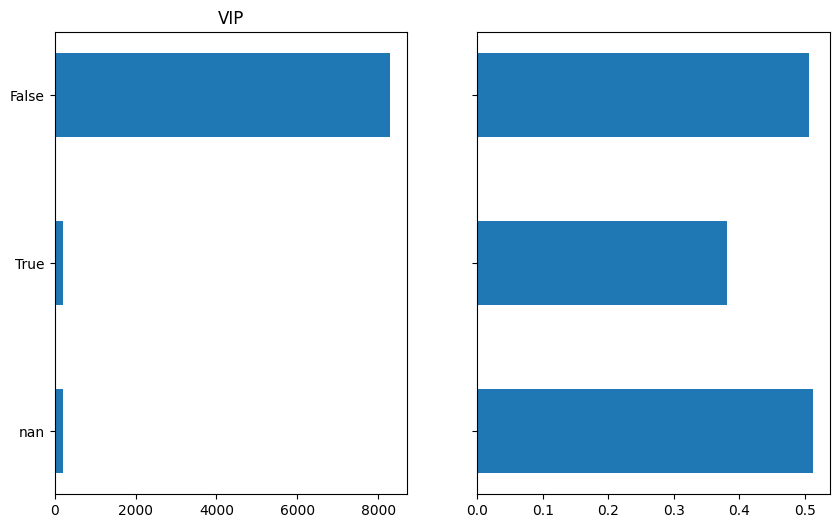

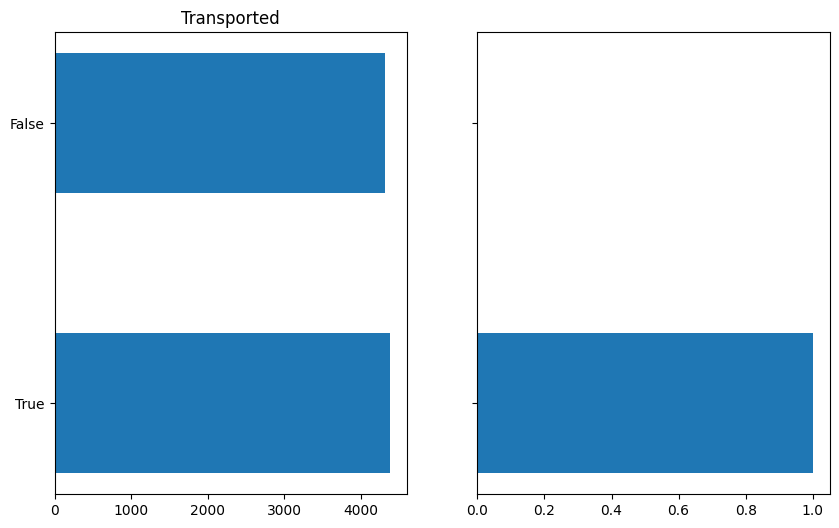

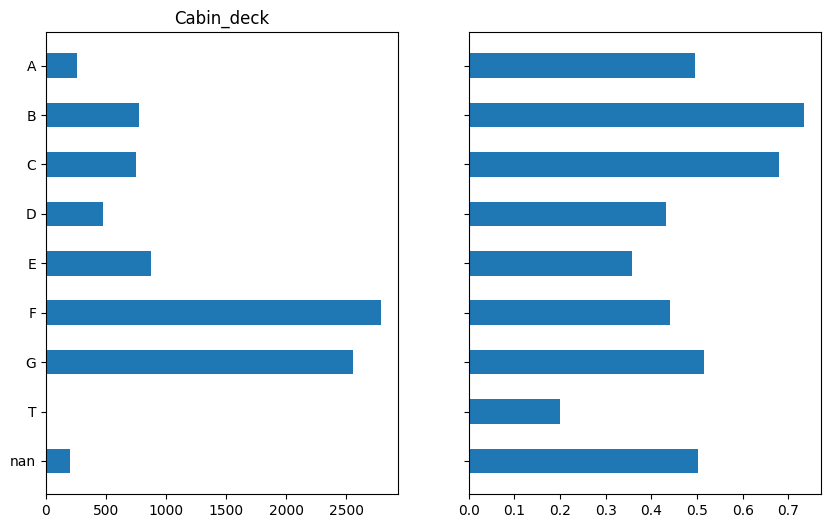

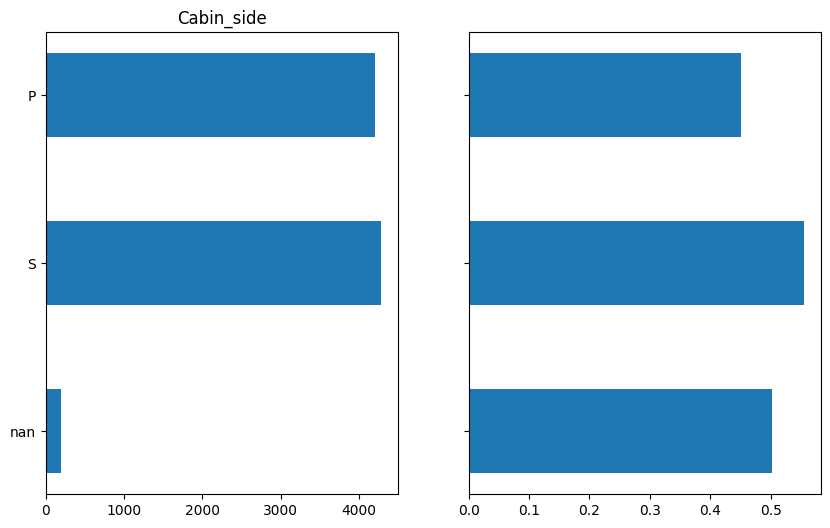

In [8]:
for col, label, value in uniq_of_cols:
    count, rate = np.array(value)[:, 0].astype(int), np.array(value)[:, 1].astype(float)
    if type(label[0]) == bool:
        label = ['False', 'True']
        label = label + ['nan'] if len(count) == 3 else label
    _arr = np.array(sorted(zip(label, count, rate), reverse=True, key=lambda x: x[0]))
    label, count, rate = _arr[:, 0], _arr[:, 1].astype(int), _arr[:, 2].astype(float)
    _, ax = plt.subplots(1, 2, figsize=(10, 6))
    ax[0].barh(label, count, height=.5)
    ax[0].set_title(col)
    ax[1].barh(label, rate, height=.5)
    ax[1].tick_params(labelleft=False)

plt.show()

In [9]:
# d = d_cab.copy()
# for i in range(len(uniq_of_cols)):
#     colx, labx, valx = uniq_of_cols[i]
#     for j in range(i + 1, len(uniq_of_cols)):
#         coly, laby, valy = uniq_of_cols[j]
#         dx = d[[colx, coly, 'Transported']].groupby(colx).apply(lambda x: len(x[x['Transported']]))
#         print(dx)
#         dy = d[[coly, 'Transported']].groupby(coly).apply(lambda x: len(x[x['Transported']]))
#         print(dy)
#         _, ax = plt.subplots()
#         sns.heatmap(zip(dx, dy))
#         ax.set_title(f'{colx} - {coly}')
# plt.show()

C:\Users\dcom\AppData\Local\Temp\ipykernel_19168\1123587665.py:15: RuntimeWarning: invalid value encountered in longlong_scalars
  return [p.shape[0], p['Transported'].sum() / p.shape[0]]


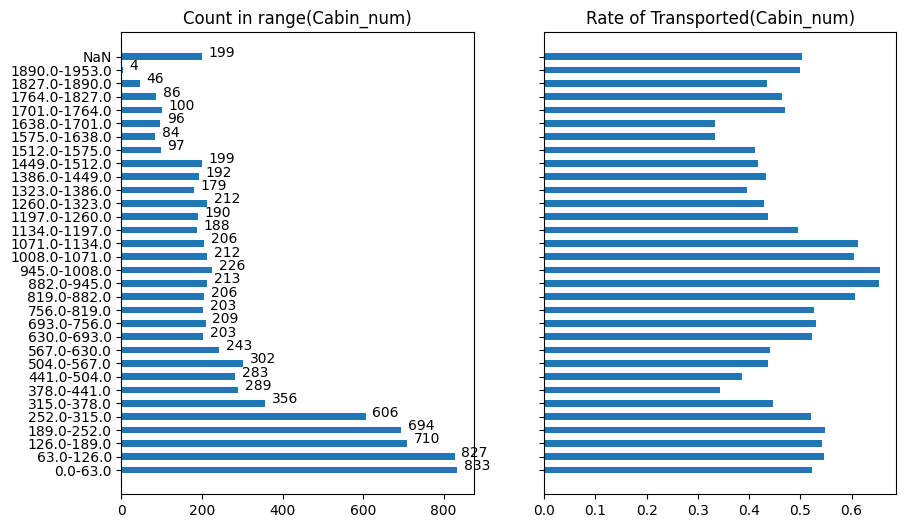

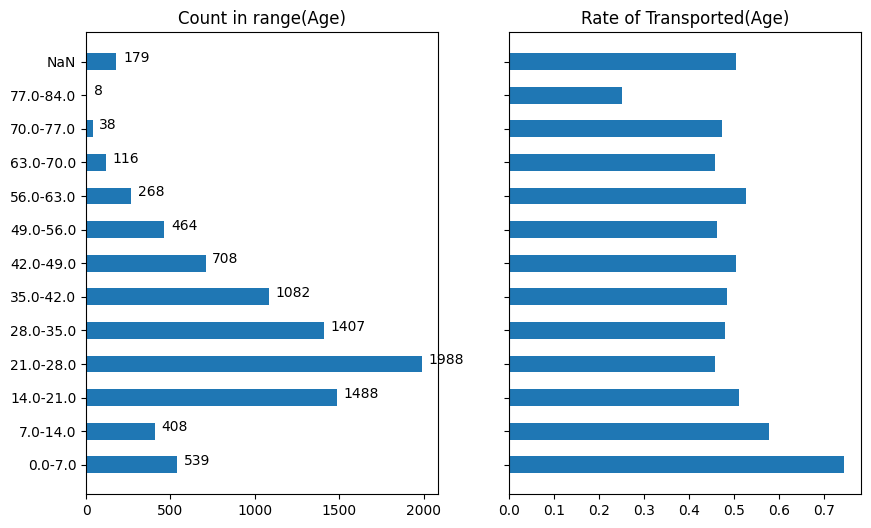

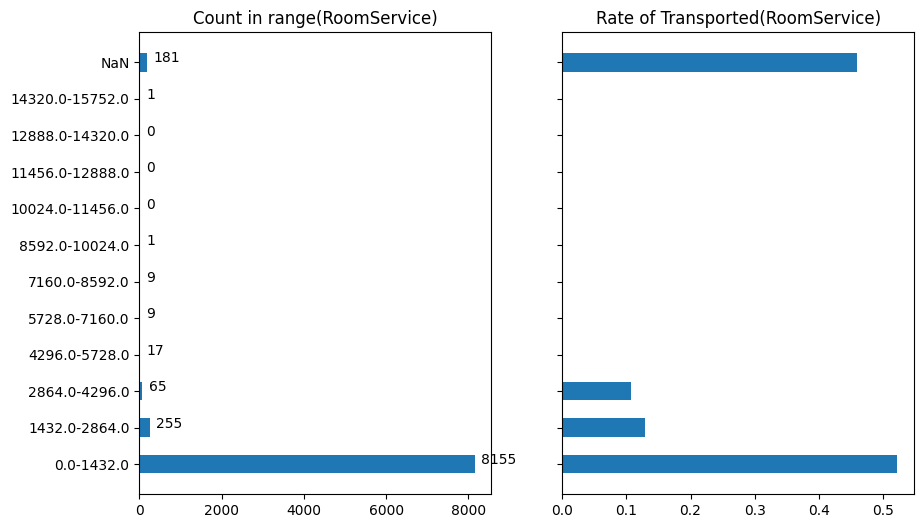

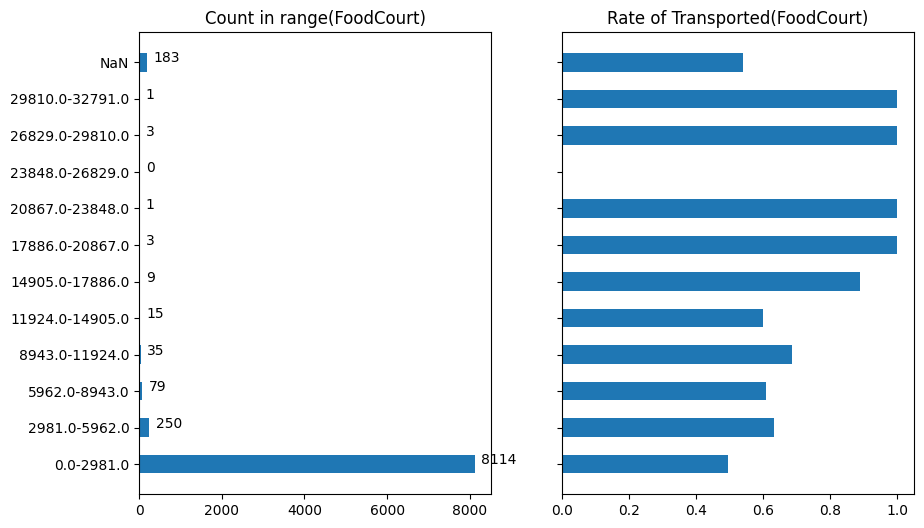

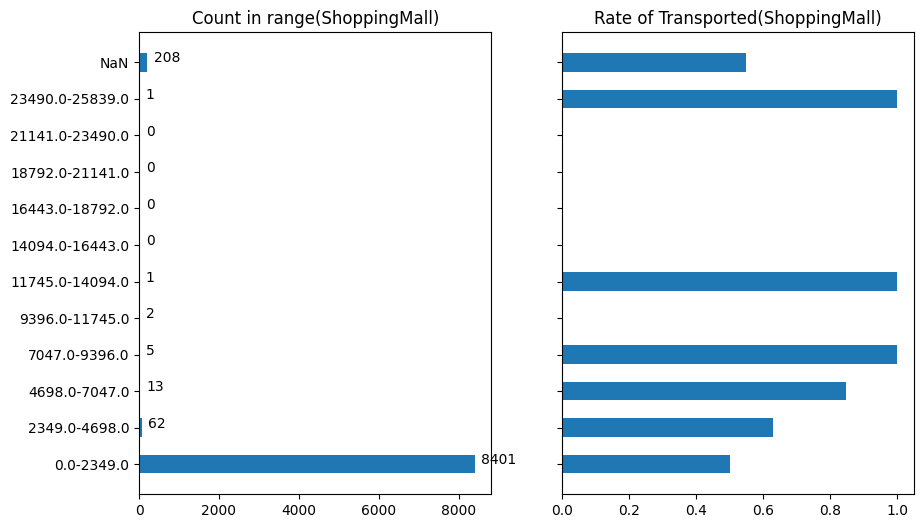

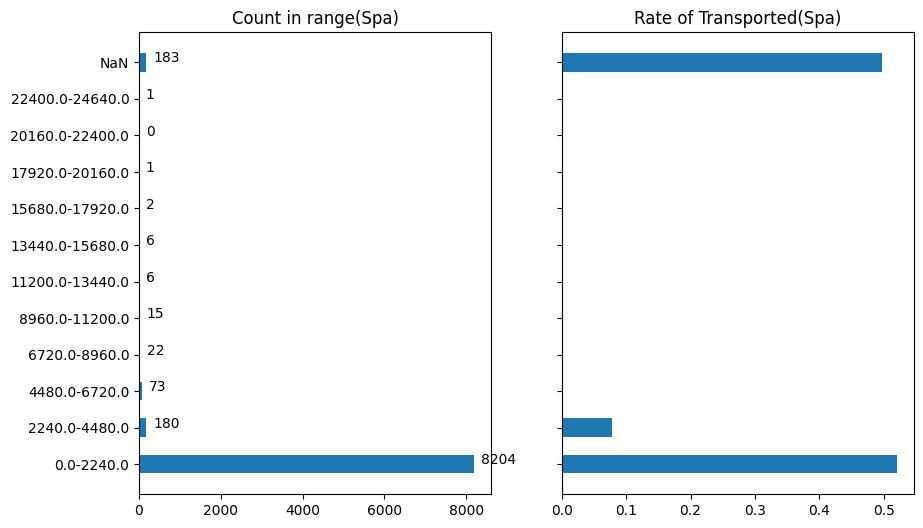

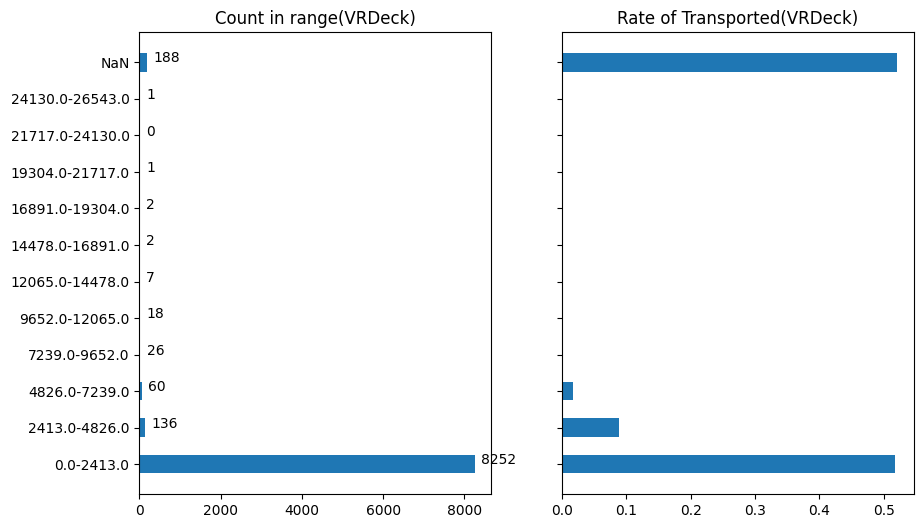

In [10]:
d = d_cab
_num_cols = ['Cabin_num', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

def plot_transported_count(col, range_splits=10):
    """
    値域毎の母数とTransported率を表示
    col is numeric colum, range_splits is num of labels
    """
    series = d[col]
    range_step = (series.max() - series.min()) // range_splits

    def __sum_rangex(x):
        p = d[(series >= x) & (series < x + range_step)]
        # print(x, x + cap_range, p.shape[0], p['Transported'].sum())
        return [p.shape[0], p['Transported'].sum() / p.shape[0]]

    def __sum_nan():
        p = d[series.isnull()]
        return [p.shape[0], p['Transported'].sum() / p.shape[0]]

    _, ax = plt.subplots(1, 2, figsize=(10, 6))
    ranges = np.arange(series.min(), series.max(), range_step)
    labels = [f'{a}-{a + range_step}' for a in ranges] + ['NaN']
    buckets = [__sum_rangex(a) for a in ranges]
    buckets += [__sum_nan()]
    buckets = np.array(buckets)
    ax[0].barh(labels, buckets[:, 0], height=.5)
    _dx = buckets[:, 0].max() / 50
    for i, h in enumerate(range(len(labels))):
        ax[0].text(buckets[i, 0] + _dx, i, int(buckets[i, 0]))
    ax[0].set_title(f'Count in range({col})')
    ax[1].barh(labels, buckets[:, 1], height=.5)
    ax[1].set_title(f'Rate of Transported({col})')
    ax[1].tick_params(labelleft=False)

plot_transported_count('Cabin_num', 30)
plot_transported_count('Age', 10)
plot_transported_count('RoomService', 10)
plot_transported_count('FoodCourt', 10)
plot_transported_count('ShoppingMall', 10)
plot_transported_count('Spa', 10)
plot_transported_count('VRDeck', 10)

plt.show()

In [11]:
d = d_src
# いずれかの列に欠損値がある行の数
def count_rows_of_nan_cols(d):
    return d[d.isnull().any(axis=1)].shape[0]

_cnt = count_rows_of_nan_cols(d)
print(f'any-column-nan rows: {_cnt}/{len(d)} ({_cnt/len(d):.2f})' )

any-column-nan rows: 2087/8693 (0.24)


* データは8693件
* Transportedは半々（予測対象がほぼ均等に分類されている）
    * 学習データのオーバーサンプリングや重み付け等は不要か
* 全データ（行）のうち項目（列）に欠損値のある割合は24%ある
    * 24%を除外するか否か

In [12]:
def __gen_boolnum():
    return {False: 0, True: 1, np.nan: -1}

def __gen_ordna(x):
    r = {k: i for i, k in enumerate(x)}
    r.update({np.nan: -1})
    return r

ordinal_defs = {
    'HomePlanet': __gen_ordna(['Europa', 'Earth', 'Mars']),
    'CryoSleep': __gen_boolnum(),
    'Cabin_deck': __gen_ordna(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']),
    'Cabin_side': __gen_ordna(['P', 'S']),
    'Destination': __gen_ordna(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e']),
    'VIP': __gen_boolnum(),
#     'Transported': __gen_boolnum()
}

for k, v in ordinal_defs.items():
    print(k, v)


HomePlanet {'Europa': 0, 'Earth': 1, 'Mars': 2, nan: -1}
CryoSleep {False: 0, True: 1, nan: -1}
Cabin_deck {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7, nan: -1}
Cabin_side {'P': 0, 'S': 1, nan: -1}
Destination {'TRAPPIST-1e': 0, 'PSO J318.5-22': 1, '55 Cancri e': 2, nan: -1}
VIP {False: 0, True: 1, nan: -1}


In [13]:
d = d_cab.copy()

features_ord = ['HomePlanet', 'CryoSleep', 'Cabin_deck', 'Cabin_side', 'Destination', 'VIP']
features_num = ['Cabin_num', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

def my_ordinal_encode(d):
    for col, defs in ordinal_defs.items():
        d[col] = d[col].map(defs)
    return d

def my_fillna(d):
    for col in features_num:
        d.loc[d[col].isna(), col] = -1
    return d

d.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin_deck,Cabin_num,Cabin_side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0.0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0.0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0.0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0.0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1.0,S


In [14]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
 14  Cabin_deck    8494 non-null   object 
 15  Cabin_num     8494 non-null   float64
 16  Cabin_side    8494 non-null   object 
dtypes: bool(1), float64(7), object(9)
memory usage: 1.1+ MB


In [15]:
# 学習・予測データとして変換
def prepare_dataset(d, fillna=True):
    d = split_cabin(d)
    d = my_ordinal_encode(d)
    if fillna:
        d = my_fillna(d)
    return d

d = prepare_dataset(d_src)
features = features_ord + features_num
x = d[features]
y = d['Transported']

print(y.info())
print(x.info())

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: Transported
Non-Null Count  Dtype
--------------  -----
8693 non-null   bool 
dtypes: bool(1)
memory usage: 8.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   int64  
 1   CryoSleep     8693 non-null   int64  
 2   Cabin_deck    8693 non-null   int64  
 3   Cabin_side    8693 non-null   int64  
 4   Destination   8693 non-null   int64  
 5   VIP           8693 non-null   int64  
 6   Cabin_num     8693 non-null   float64
 7   Age           8693 non-null   float64
 8   RoomService   8693 non-null   float64
 9   FoodCourt     8693 non-null   float64
 10  ShoppingMall  8693 non-null   float64
 11  Spa           8693 non-null   float64
 12  VRDeck        8693 non-null   float64
dtypes: float64(7), int64(6)
memory usage: 

In [18]:
RANDOM_STATE = 31

# from sklearn.ensemble import RandomForestClassifier
# model = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
# model.fit(x, y)

import xgboost as xgb
model = xgb.XGBClassifier(
    n_estimators=200, 
    max_depth=1,
    # early_stopping_rounds=10,
    random_state=RANDOM_STATE)
model.fit(x, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=31, ...)

In [19]:
t = t_src.copy()
t = prepare_dataset(t)
t.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Cabin_deck,Cabin_num,Cabin_side
0,0013_01,1,1,G/3/S,0,27.0,0,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,6,3.0,1
1,0018_01,1,0,F/4/S,0,19.0,0,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,5,4.0,1
2,0019_01,0,1,C/0/S,2,31.0,0,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,2,0.0,1
3,0021_01,0,0,C/1/S,0,38.0,0,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,2,1.0,1
4,0023_01,1,0,F/5/S,0,20.0,0,10.0,0.0,635.0,0.0,0.0,Brence Harperez,5,5.0,1


In [20]:
test_x = t[features]

pred = model.predict(test_x)
submission = pd.DataFrame(zip(t['PassengerId'], pred.astype(bool)), columns=['PassengerId', 'Transported'])
print(submission.info())
submission.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB
None


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [21]:
submission.to_csv('submission.csv', index=False)